## Библиотеки

In [93]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import catboost
from catboost import *

from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score

sns.set_style(style='darkgrid')

## Загрузка данных.

Получим список всех файлов из папки "data". Всего должно быть 43 файла.

In [94]:
files = os.listdir('data')
print('Список файлов папки "data" верен.') if len(files)==43 else print('Список файлов папки "data" неверен.')

Список файлов папки "data" верен.


Создаём пустой датасет, для заполнения. "entry_id" - будем использовать как индекс.

In [95]:
dataframe = pd.DataFrame(columns= ['entry_id', 'country', 'variety', 'winery', 'designation',
                                    'points', 'price', 'province', 'region', 'taster_name', 
                                    'title', 'description'])
dataframe = dataframe.set_index('entry_id')       # index column
dataframe

,country,variety,winery,designation,points,price,province,region,taster_name,title,description
entry_id,,,,,,,,,,,


Теперь заполним датасет "dataframe" данными из файлов в папке "data".

In [96]:
for file in files:
    dataframe = pd.concat([dataframe, pd.read_csv('data/'+file, sep=';', index_col='entry_id')], ignore_index=False)

In [97]:
dataframe = dataframe.sort_index()        #sort by index
print(f'Датасет имеет {dataframe.shape[0]} строк и {dataframe.shape[1]} столбцов.')
dataframe.head()

Датасет имеет 149908 строк и 11 столбцов.


,country,variety,winery,designation,points,price,province,region,taster_name,title,description
entry_id,,,,,,,,,,,
1,Italy,White Blend,Nicosia,Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),"Aromas include tropical fruit, broom, brimston..."
1,Italy,White Blend,Nicosia,Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),"Aromas include tropical fruit, broom, brimston..."
2,Portugal,Portuguese Red,Quinta dos Avidagos,Avidagos,87,15.0,Douro,NaN,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth..."
3,US,Pinot Gris,Rainstorm,NaN,87,14.0,Oregon,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and..."
4,US,Riesling,St. Julian,Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexаnder Peаrtree,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ..."


## Подготовка данных.

Описание данных из датафрейма "dataframe".

| переменная  | тип       | описание                                                                         |
| :---------- | :-------- | :------------------------------------------------------------------------------- |
| entry_id    | integer   | ID записи                                                                        |
| country     | character | Страна происхождения вина                                                        |
| variety     | character | Сорт винограда                                                                   |
| winery      | character | Винодельня                                                                       |
| designation | character | Название виноградника в винодельне                                               |
| points      | integer   | Баллы WineEnthusiast на шкале 1-100<br>(публикуются только отзывы с баллом >=80) |
| price       | integer   | Стоимость за бутылку, USD                                                        |
| province    | character | Провинция происхождения вина                                                     |
| region      | character | Регион в провинции происхождения вина                                            |
| taster_name | character | Имя автора отзыва                                                                |
| title       | character | Заголовок отзыва, как правило содержит винтаж (год урожая)                       |
| description | character | Описание вкусового профиля вина от автора отзыва                                 |

In [98]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149908 entries, 1 to 119988
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      149908 non-null  object 
 1   variety      149906 non-null  object 
 2   winery       149908 non-null  object 
 3   designation  106749 non-null  object 
 4   points       149908 non-null  object 
 5   price        139418 non-null  float64
 6   province     149908 non-null  object 
 7   region       125516 non-null  object 
 8   taster_name  118829 non-null  object 
 9   title        149908 non-null  object 
 10  description  149908 non-null  object 
dtypes: float64(1), object(10)
memory usage: 13.7+ MB


Колонка "desctiption" не имеет пропущенных значений. Значит "points" будет от 80 баллов.

Колонка "points" имеет тип *object*, хотя должна иметь тип *integet*. Сменим тип этой колонки.

In [99]:
dataframe.points = dataframe.points.astype('int64')

### Колонка "taster_name".

In [100]:
dataframe.taster_name.unique()

array(['Kerin O’Keefe', 'Roger Voss', 'Paul Gregutt',
       'Alexаnder Peаrtree', 'Michаel Schаchner', 'Kеrin O’Kееfе',
       'Rogеr Voss', 'Anna Lee C. Iijima', 'Virginiе Bооnе',
       'Virginiе Boonе', 'Matt Kettmann', 'Annа Lee C. Iijimа',
       'Michael Schachner', 'Alexander Peartree', 'Alеxаndеr Pеаrtrее',
       'Virginie Boone', 'Rоger Vоss', nan, 'Michaеl Schachnеr',
       'Michаеl Schаchnеr', 'Seаn P. Sullivаn', 'Virginie Bооne',
       'Sеan P. Sullivan', 'Rоgеr Vоss', 'Sеаn P. Sullivаn', 'Jim Gordon',
       'Sean P. Sullivan', 'Annа Lее C. Iijimа', 'Joе Czеrwinski',
       'Paul Grеgutt', 'Pаul Grеgutt', 'Joe Czerwinski',
       'Annе Krеbiеhl\xa0MW', 'Anne Krebiehl\xa0MW', 'Anna Lее C. Iijima',
       'Mаtt Kеttmаnn', 'Matt Kеttmann', 'Jое Czеrwinski',
       'Mаtt Kettmаnn', 'Lauren Buzzeo', 'Mike DeSimone', 'Lаurеn Buzzео',
       'Jоe Czerwinski', 'Jeff Jenssen', 'Lаuren Buzzeо', 'Lаuren Buzzeo',
       'Susan Kostrzewa', 'Susаn Kostrzеwа', 'Pаul Gregutt',
       

Мы можем заметить, что есть пропущенные значения в колонке и некоторые имена попали в список уникальных значений несколько раз. Это может говорить о неправильности заполнения колонки "taster_name" (например использование кирилицы вместо латиницы). Заменим все имена на латинские буквы и проверим число уникальных значений.

In [101]:
dataframe.loc[dataframe['taster_name'].isin(['Alexаnder Peаrtree', 'Alеxandеr Pеartrее', 'Alеxаndеr Pеаrtrее']),\
        'taster_name'] = 'Alexander Peartree'

dataframe.loc[dataframe['taster_name'].isin(['Anna Lее C. Iijima', 'Annа Lee C. Iijimа', 'Annа Lее C. Iijimа']),\
         'taster_name'] = 'Anna Lee C. Iijima'

dataframe.loc[dataframe['taster_name'].isin(['Anne Krebiehl\xa0MW', 'Annе Krеbiеhl\xa0MW']),\
         'taster_name'] = 'Anne Krebiehl MW'

dataframe.loc[dataframe['taster_name'].isin( ['Carriе Dykеs', 'Cаrrie Dykes', 'Cаrriе Dykеs']),\
         'taster_name'] = 'Carrie Dykes'

dataframe.loc[dataframe['taster_name'] == 'Christinа Pickаrd', 'taster_name'] = 'Christina Pickard'

dataframe.loc[dataframe['taster_name'].isin(['Fionа Adаms', 'Fiоna Adams', 'Fiоnа Adаms']),\
         'taster_name'] = 'Fiona Adams'

dataframe.loc[dataframe['taster_name'] == 'Jеff Jеnssеn', 'taster_name'] = 'Jeff Jenssen'

dataframe.loc[dataframe['taster_name'] == 'Jim Gоrdоn', 'taster_name'] =  'Jim Gordon'

dataframe.loc[dataframe['taster_name'].isin(['Joе Czеrwinski', 'Jоe Czerwinski', 'Jое Czеrwinski']),\
         'taster_name'] = 'Joe Czerwinski'

dataframe.loc[dataframe['taster_name'] == 'Kеrin O’Kееfе', 'taster_name'] = 'Kerin O’Keefe'

dataframe.loc[dataframe['taster_name'].isin(['Lauren Buzzeо', 'Laurеn Buzzеo', 'Laurеn Buzzео',\
                              'Lаuren Buzzeo', 'Lаuren Buzzeо', 'Lаurеn Buzzеo',\
                              'Lаurеn Buzzео']), 'taster_name'] = 'Lauren Buzzeo'

dataframe.loc[dataframe['taster_name'].isin(['Mаtt Kеttmаnn', 'Matt Kеttmann', 'Mаtt Kettmаnn']), 'taster_name'] = 'Matt Kettmann'

dataframe.loc[dataframe['taster_name'].isin(['Michaеl Schachnеr', 'Michаel Schаchner', 'Michаеl Schаchnеr']),\
          'taster_name'] = 'Michael Schachner'

dataframe.loc[dataframe['taster_name'].isin(['Mike DeSimоne', 'Mikе DеSimonе', 'Mikе DеSimоnе']),\
         'taster_name'] = 'Mike DeSimone'

dataframe.loc[dataframe['taster_name'].isin(['Paul Grеgutt', 'Pаul Gregutt', 'Pаul Grеgutt']), 'taster_name'] =  'Paul Gregutt'

dataframe.loc[dataframe['taster_name'].isin(['Rogеr Voss', 'Rоger Vоss', 'Rоgеr Vоss']), 'taster_name'] = 'Roger Voss'

dataframe.loc[dataframe['taster_name'].isin(['Seаn P. Sullivаn', 'Sеan P. Sullivan', 'Sеаn P. Sullivаn']), 'taster_name'] = 'Sean P. Sullivan'

dataframe.loc[dataframe['taster_name'].isin([ 'Susan Kostrzеwa', 'Susan Kоstrzewa', 'Susan Kоstrzеwa',\
                               'Susаn Kostrzewа', 'Susаn Kostrzеwа', 'Susаn Kоstrzewа',\
                               'Susаn Kоstrzеwа',]), 'taster_name'] = 'Susan Kostrzewa'

dataframe.loc[dataframe['taster_name'].isin(['Virginie Bооne', 'Virginiе Boonе', 'Virginiе Bооnе']), 'taster_name'] = 'Virginie Boone'

Проверим не осталось ли дублированных значений в колонке.

In [102]:
dataframe.taster_name.unique()

array(['Kerin O’Keefe', 'Roger Voss', 'Paul Gregutt',
       'Alexander Peartree', 'Michael Schachner', 'Anna Lee C. Iijima',
       'Virginie Boone', 'Matt Kettmann', nan, 'Sean P. Sullivan',
       'Jim Gordon', 'Joe Czerwinski', 'Anne Krebiehl MW',
       'Lauren Buzzeo', 'Mike DeSimone', 'Jeff Jenssen',
       'Susan Kostrzewa', 'Carrie Dykes', 'Fiona Adams',
       'Christina Pickard'], dtype=object)

Все имена уникальны. Теперь найдём сколько уникальных значений есть в этом столбце. Помним, что *nunique()* не учитывает пропущенные значения.

In [103]:
dataframe.taster_name.nunique() + 1

20

Всего 20 уникальных значений, включая пропущенные згначения.

### Дубликаты строк.

Посмотрим есть ли дублирующиеся строки в нашем датасете. Если они есть, то от них нужно избавиться, чтобы анализ данных был верен и при обучении модели прогнозирования не произошло переобучения.

In [104]:
dataframe.duplicated().sum()

29979

Всего в датасете **29 979** дубликатов строк. Удалим их все.

In [105]:
dataframe = dataframe.drop_duplicates(keep='first')
dataframe.shape

(119929, 11)

После удаления дублирующихся строк отсталось 119929 записей.

### Описательная статистика.

У нас только 2 числовые характеристики "points" и "price". Посмотрим на описательную статистику для них.

In [106]:
dataframe.describe()

,points,price
count,119929.000000,111538.000000
mean,88.442145,35.626109
std,3.093275,42.112910
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


In [107]:
print(f'Медианное значение "points" = {dataframe.points.median()}, a "price" = {dataframe.price.median()}')

Медианное значение "points" = 88.0, a "price" = 25.0


В колонке "price" есть пропущенные значения. На данном этапе не бдем с ними ничего делать.

Для "points" mean = 88.4, median = 88.0, min = 80.0, max = 100.0. 

Для "price" mean = 35.6, median = 25, min = 4.0, max = 3300.0. Для данной зарактеристики есть выбросы, так как медиана равно 25, а максимальное значение 3300. 

Стоит построить графики распределения этих величин.

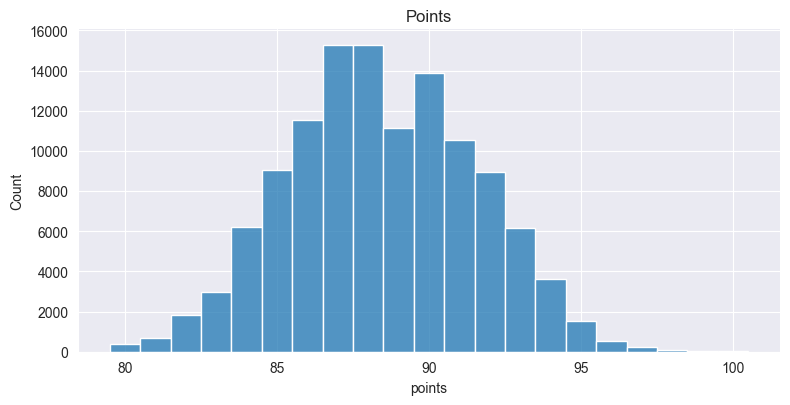

In [108]:
sns.displot(data=dataframe, x='points', discrete=True, height=4, aspect=2)
plt.title('Points');

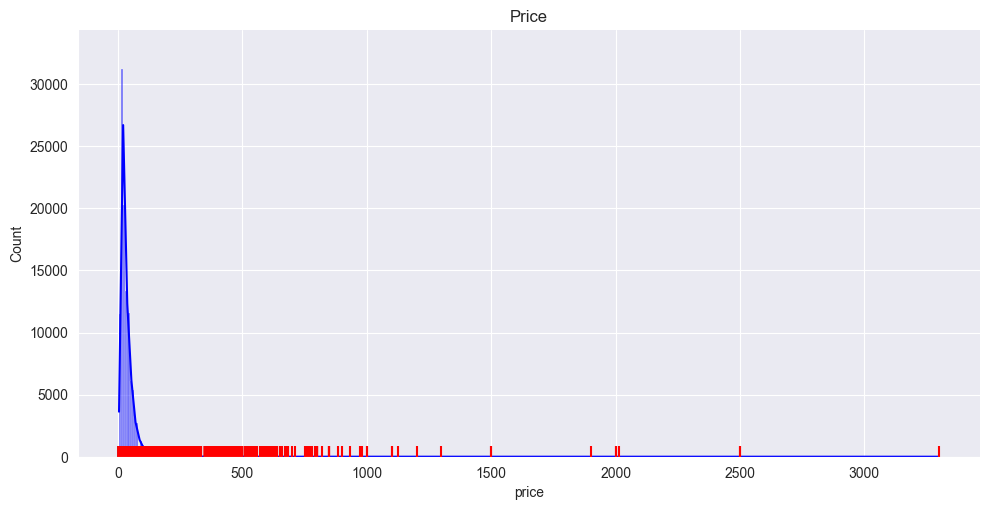

In [109]:
sns.displot(data=dataframe, x='price', bins=dataframe.price.nunique(), kde=True, color='blue', height=5, aspect=2)
sns.rugplot(data=dataframe, x='price', color='red', linewidth=1.5)
plt.title('Price');

Как и ожидалось расределение величины "points" близко к нормальному, в то время как распределние величины "price" имеет сильное смещение в сторону минимума и выбросы.

Теперь исследуем зависимость между этими величинами. 

Для начала определим коэффициент корреляции. Будем исспользовать коэффициент корреляции Спирмана. Такой выбор обусловлен тем, что переменная "price" не имеет нормального распределения и в ней присутствуют выбросы, а величина "points" - качественная.

In [110]:
spearmanr(dataframe.price, dataframe.points, nan_policy='omit', alternative='two-sided')

SignificanceResult(statistic=0.6124750550158435, pvalue=0.0)

Так как переменная "points" имеет только 21 значение (дискретная величина), а переменная "price" 390 (непрерывная), то для демонстрации связи между ними будем использовать точечный график, который объединяет непрерывную переменную (ось Y) с категориальной переменной (ось X).

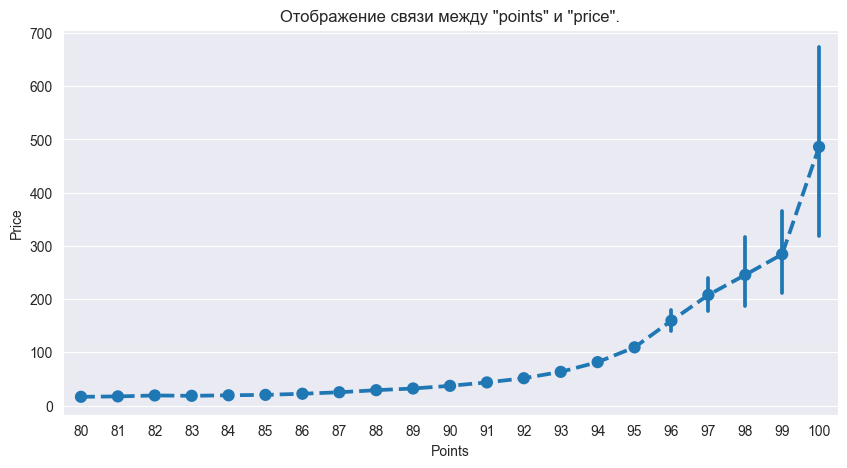

In [111]:
plt.figure(figsize=(10, 5))
sns.pointplot(x='points', y='price', data=dataframe, linestyles='--')
plt.xlabel('Points')
plt.ylabel('Price')
plt.title('Отображение связи между "points" и "price".');

Данный график показывает следующую информацию:

* Средняя стоимость вина в разбивке по баллам (представлена ​​точками на графике)
* Относительное изменение между баллами (представлено линиями, соединяющими точки)
* 95-процентный доверительный интервал (представлен вертикальными линиями, пересекающимися с точками).

Из графика видно, что вино с большим количество баллов стоит дороже, что и ожидалось.

*Как зовут ТОП-5 самых продуктивных авторов отзывов (по числу отзывов).*

In [112]:
dataframe.taster_name.value_counts()[:5]

taster_name
Roger Voss           23558
Michael Schachner    14039
Kerin O’Keefe         9697
Paul Gregutt          8867
Virginie Boone        8708
Name: count, dtype: int64

ТОП-5: Roger Voss, Michael Schachner, Kerin O’Keefe, Paul Gregutt, Virginie Boone

*Вина из каких стран каждый из ТОП-5 в основном оценивает.*

In [113]:
dataframe[dataframe.taster_name.isin(dataframe.taster_name.value_counts()[:5].index)].\
    groupby('taster_name').country.value_counts()

taster_name        country     
Kerin O’Keefe      Italy            9697
Michael Schachner  Spain            6046
                   Chile            4049
                   Argentina        3542
                   Uruguay            98
                   Italy              76
                   US                 71
                   Mexico             63
                   Brazil             49
                   France             20
                   Peru               16
                   Portugal            9
Paul Gregutt       US               8666
                   Canada            159
                   France             34
                   Spain               4
                   Italy               4
Roger Voss         France          17150
                   Portugal         5223
                   Austria          1064
                   Italy              96
                   South Africa       22
                   US                  2
                   Greece

**Kerin O’Keefe**: Italy (9697)

**Michael Schachner**: Spain (6046), Chile (4049), Argentina (3542)

**Paul Gregutt**: US (8666)

**Roger Voss**: France (17150), Portugal (5223), Austria (1064)

**Virginie Boone**: US (8708)

*Отличаются ли ценовые диапазон вин, которые оценивает каждый из ТОП-5?*

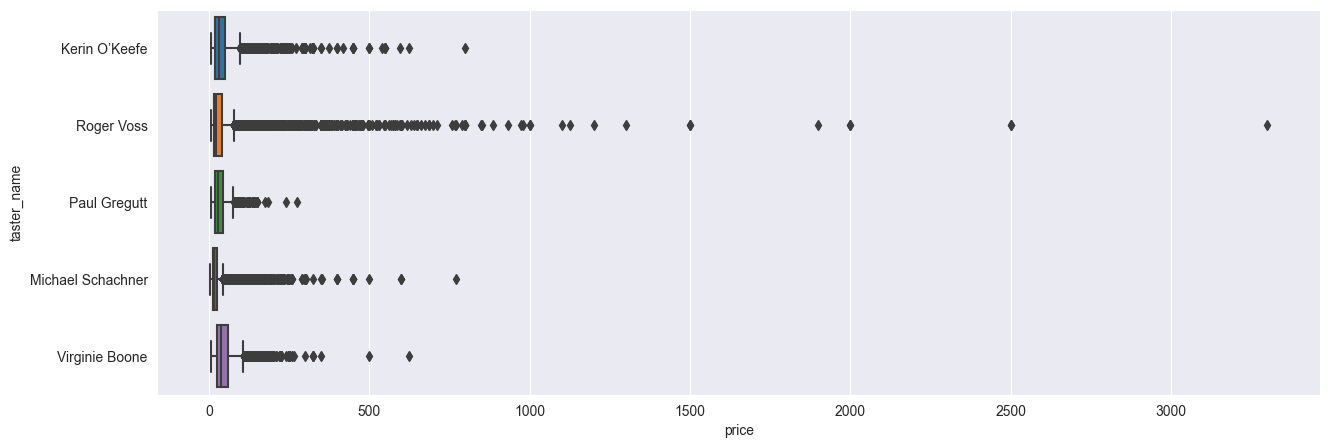

In [114]:
plt.figure(figsize=(15, 5))
sns.boxplot(x="price", 
            y="taster_name", 
            data=dataframe[dataframe.taster_name.isin(dataframe.taster_name.value_counts()[:5].index)]);

Отличия в диапазонах есть. Больше всего диапазон у Roger Voss, меньше всего Paul Gregutt.

### Дополнительно.

In [115]:
df_90 = dataframe[dataframe.points>90]
df_90.head()

,country,variety,winery,designation,points,price,province,region,taster_name,title,description
entry_id,,,,,,,,,,,
120,France,Riesling,Dopff & Irion,Schoenenbourg Grand Cru Vendanges Tardives,92,80.0,Alsace,Alsace,NaN,Dopff & Irion 2004 Schoenenbourg Grand Cru Ven...,Medium-gold in color. Complex and inviting nos...
121,Italy,Nebbiolo,Ceretto,Bricco Rocche Prapó,92,70.0,Piedmont,Barolo,NaN,Ceretto 2003 Bricco Rocche Prapó (Barolo),"Slightly backward, particularly given the vint..."
122,US,Chardonnay,Matrix,Stuhlmuller Vineyard,92,36.0,California,Alexander Valley,NaN,Matrix 2007 Stuhlmuller Vineyard Chardonnay (A...,The vineyard is one of the better Chardonnay s...
123,US,Zinfandel,Mauritson,Rockpile Cemetary Vineyard,92,39.0,California,Rockpile,NaN,Mauritson 2007 Rockpile Cemetary Vineyard Zinf...,Defines Rockpile Zinfandel in intensity of fru...
124,Australia,Shiraz-Cabernet Sauvignon,Henry's Drive Vignerons,Parson's Flat,92,40.0,South Australia,Padthaway,Joe Czerwinski,Henry's Drive Vignerons 2006 Parson's Flat Shi...,The blend is roughly two-thirds Shiraz and one...


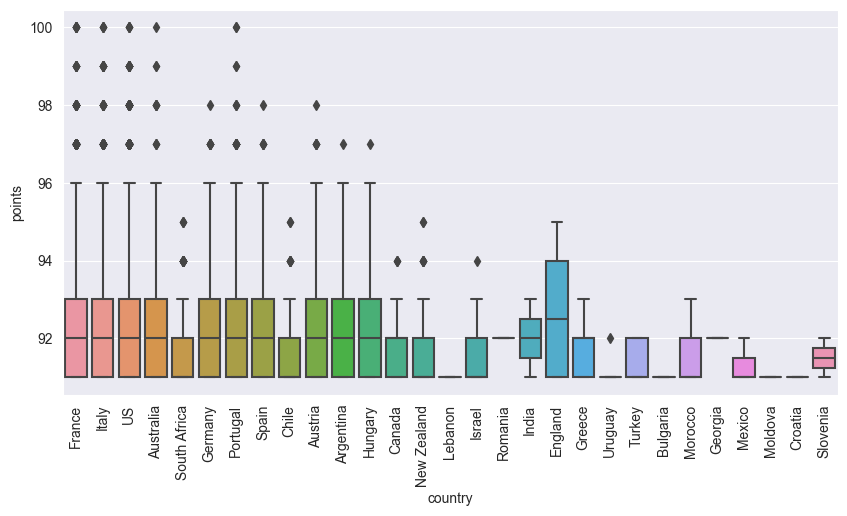

In [117]:
plt.figure(figsize=(10,5))
sns.boxplot(x="country", y="points", data=df_90)
plt.xticks(rotation=90);

Наивысший рейтинг у виина из стран Франция, Италия, США, Австралия, Германия, Португалия, Испания, Австрия.

Теперь посмотрим на средний рейтинг по винодельне и выведем топ-10.

In [118]:
df_90.groupby('winery').points.mean().reset_index(name="mean_points").sort_values('mean_points', ascending=False).head(10)

,winery,mean_points
266,Araujo,98.000000
3446,J.L. Chave,97.000000
2994,Gandona,97.000000
4663,Ovid,97.000000
4516,Napa Angel,97.000000
5905,Tenuta dell'Ornellaia,96.888889
5379,Salon,96.800000
1513,Château Pétrus,96.666667
348,Avignonesi,96.600000
6228,Verité,96.125000


Выведем ТОП-10 провинций по качеству вина.

In [119]:
df_90.groupby('province').points.mean().reset_index(name="mean_points").sort_values('mean_points', ascending=False).head(10)

,province,mean_points
110,Madeira,94.181818
193,Südburgenland,94.000000
126,Moscatel do Douro,93.500000
216,Wachau,93.242152
212,Vinho Licoroso,93.000000
34,Cape South Coast,93.000000
47,Colares,93.000000
158,Port,92.991837
202,Tokaji,92.920000
167,Rheingau,92.777778


### Пропущенные значения.

In [120]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119929 entries, 1 to 119988
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      119929 non-null  object 
 1   variety      119928 non-null  object 
 2   winery       119929 non-null  object 
 3   designation  85394 non-null   object 
 4   points       119929 non-null  int64  
 5   price        111538 non-null  float64
 6   province     119929 non-null  object 
 7   region       100428 non-null  object 
 8   taster_name  95012 non-null   object 
 9   title        119929 non-null  object 
 10  description  119929 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 15.0+ MB


Пропущенные значения есть в колонках "variety", "designation", "price", "region", "taster_name".

*"variety"*

Это значение можно получить из колонки "description". Чобы видеть полное содержание её, добавим следующую опцию.

In [121]:
pd.set_option('display.max_colwidth', None)

In [122]:
dataframe[dataframe.variety.isnull()]

,country,variety,winery,designation,points,price,province,region,taster_name,title,description
entry_id,,,,,,,,,,,
82318,Chile,NaN,Carmen,NaN,88,17.0,Maipo Valley,NaN,NaN,Carmen 1999 (Maipo Valley),"A chalky, dusty mouthfeel nicely balances this Petite Syrah's bright, full blackberry and blueberry fruit. Wheat-flour and black-pepper notes add interest to the bouquet; the wine finishes with herb and an acorny nuttiness. A good first Chilean wine for those more comfortable with the Californian style. It's got tannins to lose, but it's very good."


Из описания сорт винограда "Petite Sirah".

In [123]:
dataframe.variety.fillna('Petite Sirah', inplace=True)

*"designation"*

Название виноградника можно получить из колонки "title" (вторая строка).

In [124]:
designation_unique = dataframe[dataframe.designation.notnull()].designation.unique()

In [125]:
for title_str in dataframe[dataframe.designation.isnull()].title:
    for des in designation_unique:
        if des in title_str:
            dataframe.loc[dataframe.title==title_str, 'designation'] = des
            break

In [126]:
sum(dataframe.designation.isnull())

0

Колонка заполнена.

*"region"*

Регион указан в скобках колонки "title". Изучив датасет видно, что если регион отсутствует, то он будет такой же как провинция.

In [127]:
dataframe['region'].fillna(dataframe['province'], inplace=True)

In [128]:
sum(dataframe.region.isnull())

0

*"taster_name"*

Здесь будем отталкиваться от региона. Будем предполагать, что отзыв оставлял тот сомелье, который чаще всего работает в нём. Если для регионе не работал никакой сомелье, то выберем самого популярного в провинции и т.д.

In [129]:
taster_names = ['Kerin O’Keefe', 'Roger Voss', 'Paul Gregutt',
                'Alexander Peartree', 'Michael Schachner', 'Anna Lee C. Iijima',
                'Virginie Boone', 'Matt Kettmann', 'Sean P. Sullivan',
                'Jim Gordon', 'Joe Czerwinski', 'Anne Krebiehl MW',
                'Lauren Buzzeo', 'Mike DeSimone', 'Jeff Jenssen',
                'Susan Kostrzewa', 'Carrie Dykes', 'Fiona Adams',
                'Christina Pickard']

In [130]:
# регион
data = dataframe.groupby('region')['taster_name'].agg(pd.Series.mode).reset_index(name="new_name")
data = data[data.new_name.isin(taster_names)]
dataframe = dataframe.merge(data, on='region', how='left')
dataframe['taster_name'].fillna(dataframe['new_name'], inplace=True)
dataframe = dataframe.drop(columns=['new_name'])

In [131]:
# провинция
data = dataframe.groupby('province')['taster_name'].agg(pd.Series.mode).reset_index(name="new_name")
data = data[data.new_name.isin(taster_names)]
dataframe = dataframe.merge(data, on='province', how='left')
dataframe['taster_name'].fillna(dataframe['new_name'], inplace=True)
dataframe = dataframe.drop(columns=['new_name'])

In [132]:
# страна
data = dataframe.groupby('country')['taster_name'].agg(pd.Series.mode).reset_index(name="new_name")
data = data[data.new_name.isin(taster_names)]
dataframe = dataframe.merge(data, on='country', how='left')
dataframe['taster_name'].fillna(dataframe['new_name'], inplace=True)
dataframe = dataframe.drop(columns=['new_name'])

In [133]:
sum(dataframe.taster_name.isnull())

0

**Новая колонка *"year"***

Из "title" было бы хорошо получить год урожая. Это было бы просто, но в этой колонке иногда содеждатся 4-х значные числа, которые не имеют отношения к году. Однако мы знаем, что год написан после названия винодельни и перед названием виноградника. Таким образом, если мы удали эти названия, то оставшиеся 4 цифры будут годом.

In [134]:
dataframe['year'] = ''
for title_str, winery_str, designation_str  in zip(dataframe.title, dataframe.winery, dataframe.designation):
    title_str_new = title_str.replace(winery_str, '')
    title_str_new = title_str_new.replace(designation_str, '')
    dataframe.loc[dataframe.title==title_str, 'year'] = title_str_new

In [135]:
dataframe['year'] = dataframe.year.str.extract(r'(\d{4})')

Здесь остануться незаполненные значения, так что оставим их как "NV". Если бы в описании было указанно, почему эти значения отсутствуют, то можно было бы подумать о том, чем их заполнять, но мы так и оставим.

In [136]:
dataframe.year.fillna('NV', inplace=True)

In [137]:
sum(dataframe.year.isnull())

0

*"price"*

Переменную "price" можно рассмотреть как целевую. Так как нашей основной задачей не является точное предсказание этой переменной, то построим простую модель, где цена будет зависеть лишь от баллов.

In [138]:
X = dataframe[dataframe.price.notnull()][['points']]
y = dataframe[dataframe.price.notnull()].price
X_test = dataframe[dataframe.price.isnull()][['points']]

In [139]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=23)

In [140]:
model = CatBoostRegressor(random_state=23)
model.fit(X_train, y_train, verbose=False, plot=False);

Проверим правильность модели.

In [141]:
r2_score(y_val, model.predict(X_val))

0.2232423474941434

Получим предсказания цены.

In [142]:
y_pred = model.predict(X_test)

Осталось лишь добавить эти данные в датасет, что не составит труда при необходимости.